In [116]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.linear_model import RANSACRegressor
from scipy.interpolate import UnivariateSpline

sys.path.append('../src/')
from st_utils import correct_tissue_names, correct_platform_panel,name_parser

from constants import CORRECT_PLATFORM_PANEL
from constants import matching_cores, CB_COLORS_5
from constants import SAMPLES
from constants import xenium_breast_htma_matching_cores
from constants import merscope_breast_htma_matching_cores
from constants import cosmx_multitissue_htma_matching_cores


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')


year = '2024'

samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)

working directory: /mnt/disks/store/ist_benchmarking
['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


In [97]:
by_sample = False

# gene by gene - platform variation

In [113]:
metric = f'count'
df_m = pd.DataFrame()
for sample in samples:
    print (f'sample: {sample}')
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample, df_t)
    # Reindex normal tissue cores 
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
    # Consolidate tissue type
    # df_t = df_t.replace({'LN':'Lymph node','MARKER':'Marker'}) if 'htma' in sample else df_t
    df_t['sample'] = sample
    df_m = pd.concat([df_m,df_t])
    
df_m = df_m.loc[df_m['core'].isin(matching_cores)]
df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)[0].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)[1])
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)[2].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']},{row['panel']}", axis=1)
df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()

if by_sample:
    df_plot = df_m.copy()
    df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
    df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

df_plot.head()

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


platform_panel,gene,"COSMX,multitissue","MERSCOPE,breast","XENIUM,breast"
0,AATK,28480.0,NaN,NaN
1,ABCC11,NaN,2657.0,21791.0
2,ABL1,64900.0,NaN,NaN
3,ABL2,39764.0,NaN,NaN
4,ACACB,34054.0,NaN,NaN


# Same plots but By TMA 

Xenium,breast CosMx,1k ['HTMA']


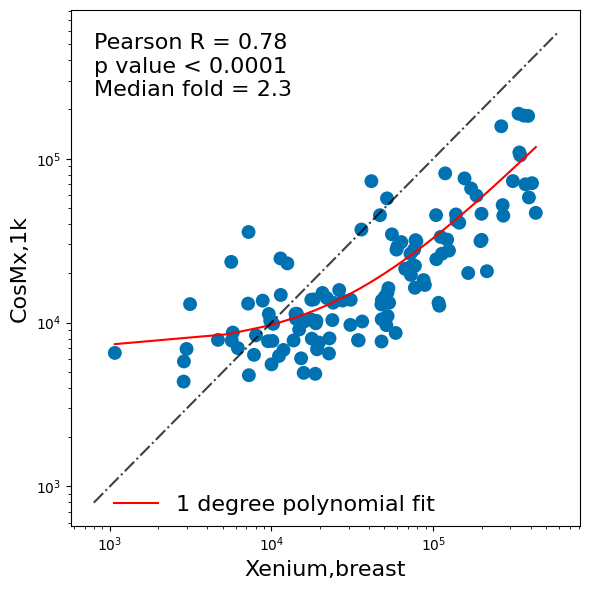

MERSCOPE,breast CosMx,1k ['HTMA']


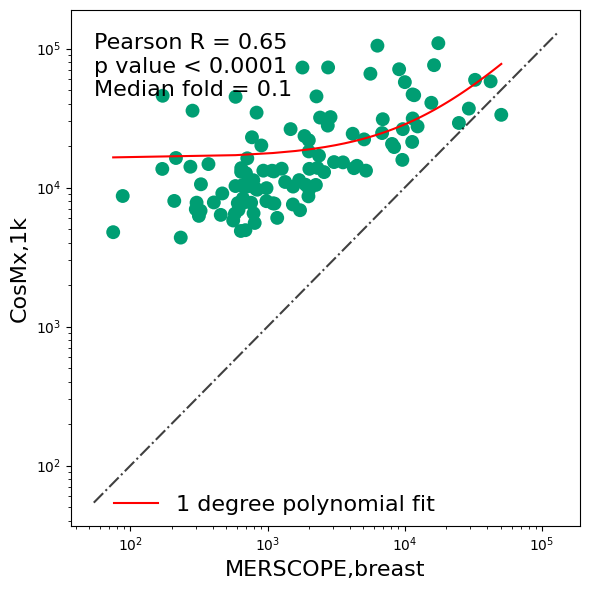

Xenium,breast MERSCOPE,breast ['HTMA']


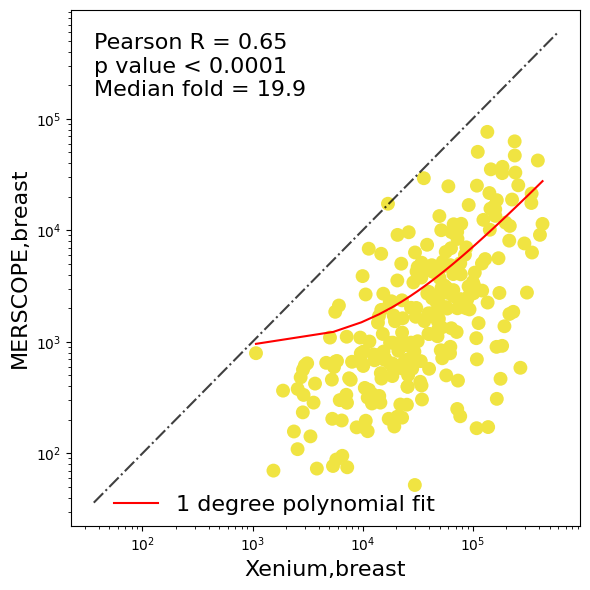

Xenium,breast CosMx,1k ['TUMOR2']


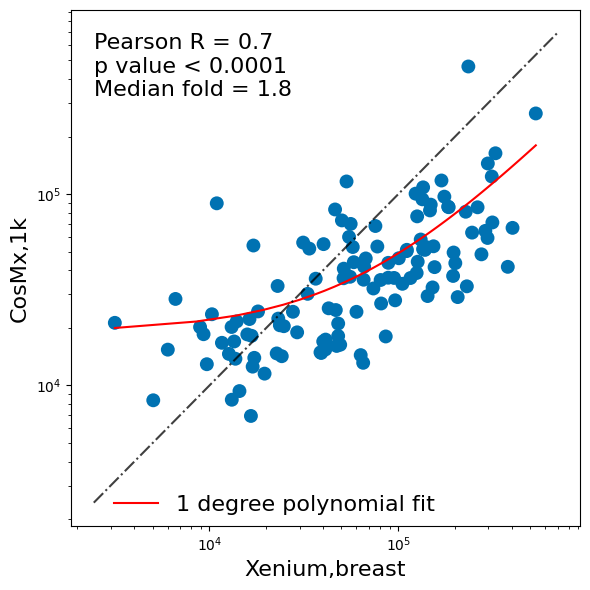

MERSCOPE,breast CosMx,1k ['TUMOR2']


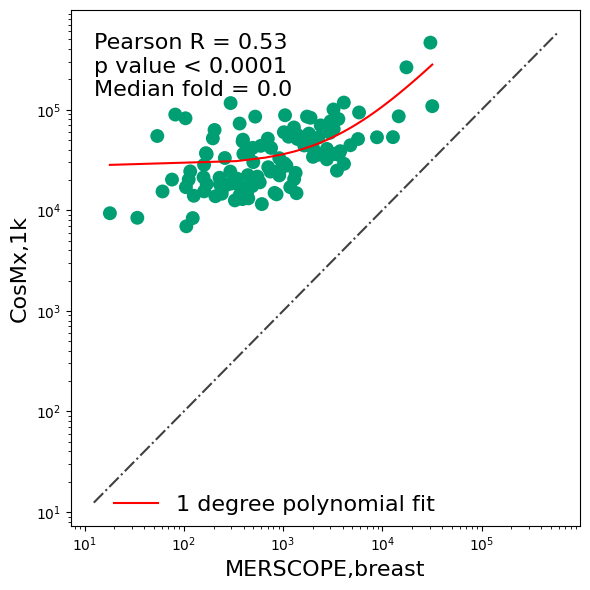

Xenium,breast MERSCOPE,breast ['TUMOR2']


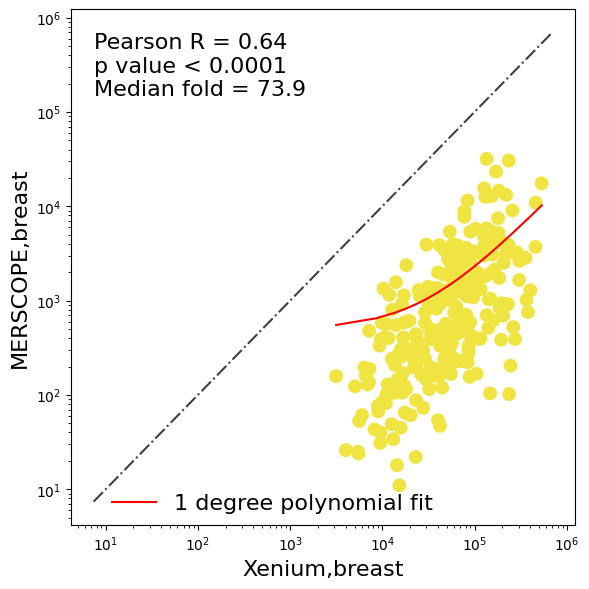

In [121]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')


if year =='2023':

    for tmas in [['HTMA'], ['NORMAL']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k',
                    'MERSCOPE,breast', 
                    'MERSCOPE,lung',
                    'Xenium,breast',
                    'Xenium,lung',
                    'Xenium,multi-tissue']

        for count, platform_panel_pair in enumerate([('Xenium,breast','CosMx,1k'),
                                    ('Xenium,lung','CosMx,1k'),
                                    ('MERSCOPE,breast','CosMx,1k'),
                                    ('MERSCOPE,lung','CosMx,1k'),
                                    ('Xenium,breast','MERSCOPE,breast'),
                                    ('Xenium,lung','MERSCOPE,lung'),
                                    ('Xenium,multi-tissue','CosMx,1k')
                                    ]):
            color_index = int(np.floor(count/2+1))

            platform_panel_1 = platform_panel_pair[0]
            platform_panel_2 = platform_panel_pair[1]

            print(platform_panel_1, platform_panel_2, tmas)

            df_pair = df_plot[['gene', platform_panel_1, platform_panel_2]]
            df_pair = df_pair.reset_index(drop=True).dropna()

            df_pair['fold'] = df_pair.apply(lambda row: round(row[platform_panel_1] /row[platform_panel_2],1), axis=1)


            # Scatter plot
            plt.figure(figsize=(6, 6))
            sns.scatterplot(data=df_pair, x=platform_panel_1, y=platform_panel_2, color=list(CB_COLORS_5.values())[color_index],edgecolor='none',s=100)

            # # Annotate genes
            # for idx, row in df_pair.iterrows():
            #     plt.annotate(row['gene'], (row[platform_panel_1], row[platform_panel_2]), fontsize=5)

            # Fit a polynomial line
            degree = 1  # Degree of the polynomial
            x = df_pair[platform_panel_1]
            y = df_pair[platform_panel_2]
            coefficients = np.polyfit(x, y, degree)
            polynomial = np.poly1d(coefficients)
            x_poly = np.linspace(min(x), max(x), 100)
            y_poly = polynomial(x_poly)

            # Plot polynomial line
            plt.plot(x_poly, y_poly, label=f'{degree} degree polynomial fit', color='red')

            fontsize = 16

            # Log scale
            plt.xscale('log')
            plt.yscale('log')

            # 1:1 dashed line
            lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            plt.plot(lims, lims, 'k-.', alpha=0.75)

            # Stats
            r, p = sp.stats.spearmanr(x, y)
            p = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"
            plt.text(lims[0], lims[1]+3, f"Pearson R = {round(r,2)}\np value {p}\nMedian fold = {round(df_pair['fold'].median(), 1)}", fontsize=fontsize, verticalalignment='top')

            # Axes and labels
            plt.xlabel(platform_panel_1, fontsize=fontsize)
            plt.ylabel(platform_panel_2, fontsize=fontsize)
            plt.legend(loc='upper center', bbox_to_anchor=(0.4, 0.1), frameon=False, fontsize=fontsize)

            # Save and show the plot
            plt.tight_layout()
            plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.png", bbox_inches='tight', transparent=True)
            # plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.eps", bbox_inches='tight', transparent=True)
            plt.close()
            # plt.show()

elif year =='2024':

    for tmas in [['HTMA'], ['TUMOR2']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k',
                    'MERSCOPE,breast', 
                    'Xenium,breast']

        for count, platform_panel_pair in enumerate([
            ('Xenium,breast','CosMx,1k'),
            ('MERSCOPE,breast','CosMx,1k'),
            ('Xenium,breast','MERSCOPE,breast'),
            ]):

            color_index = count + 1
            
            platform_panel_1 = platform_panel_pair[0]
            platform_panel_2 = platform_panel_pair[1]

            print(platform_panel_1, platform_panel_2, tmas)

            df_pair = df_plot[['gene', platform_panel_1, platform_panel_2]]
            df_pair = df_pair.reset_index(drop=True).dropna()

            df_pair['fold'] = df_pair.apply(lambda row: round(row[platform_panel_1] /row[platform_panel_2],1), axis=1)

            # Scatter plot
            plt.figure(figsize=(6, 6))
            sns.scatterplot(data=df_pair, x=platform_panel_1, y=platform_panel_2, color=list(CB_COLORS_5.values())[color_index],edgecolor='none',s=100)

            # # Annotate genes
            # for idx, row in df_pair.iterrows():
            #     plt.annotate(row['gene'], (row[platform_panel_1], row[platform_panel_2]), fontsize=5)

            # Fit a polynomial line
            degree = 1  # Degree of the polynomial
            x = df_pair[platform_panel_1]
            y = df_pair[platform_panel_2]
            coefficients = np.polyfit(x, y, degree)
            polynomial = np.poly1d(coefficients)
            x_poly = np.linspace(min(x), max(x), 100)
            y_poly = polynomial(x_poly)

            # Plot polynomial line
            plt.plot(x_poly, y_poly, label=f'{degree} degree polynomial fit', color='red')

            fontsize = 16

            # Log scale
            plt.xscale('log')
            plt.yscale('log')

            # 1:1 dashed line
            lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            plt.plot(lims, lims, 'k-.', alpha=0.75)

            # Stats
            r, p = sp.stats.spearmanr(x, y)
            p = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"
            plt.text(lims[0], lims[1]+3, f"Pearson R = {round(r,2)}\np value {p}\nMedian fold = {round(df_pair['fold'].median(), 1)}", fontsize=fontsize, verticalalignment='top')

            # Axes and labels
            plt.xlabel(platform_panel_1, fontsize=fontsize)
            plt.ylabel(platform_panel_2, fontsize=fontsize)
            plt.legend(loc='upper center', bbox_to_anchor=(0.4, 0.1), frameon=False, fontsize=fontsize)

            # Save and show the plot
            plt.tight_layout()
            plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.png", bbox_inches='tight', transparent=True)
            # plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.eps", bbox_inches='tight', transparent=True)
            # plt.close()
            plt.show()

In [122]:
polynomial

poly1d([1.81906040e-02, 4.94333194e+02])

# Core to core reproducibility

105 106
sample: xenium_breast_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


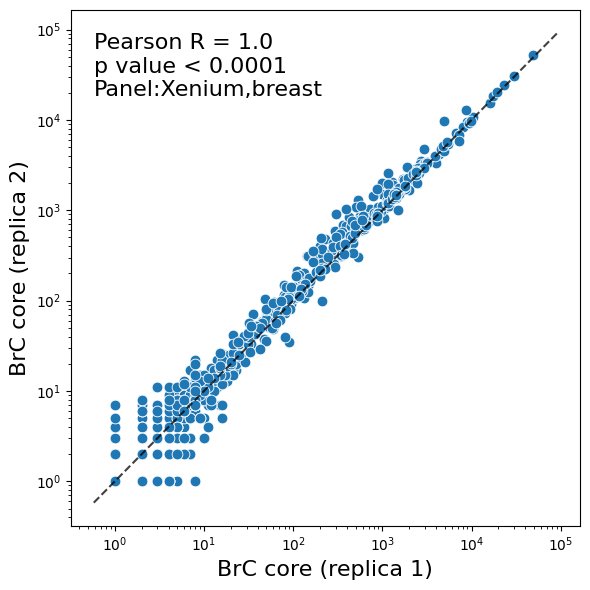

sample: xenium_panhuman_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


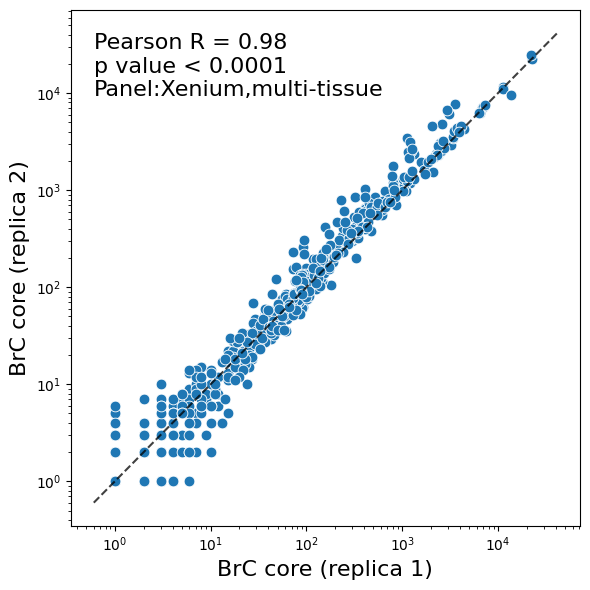

sample: xenium_lung_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


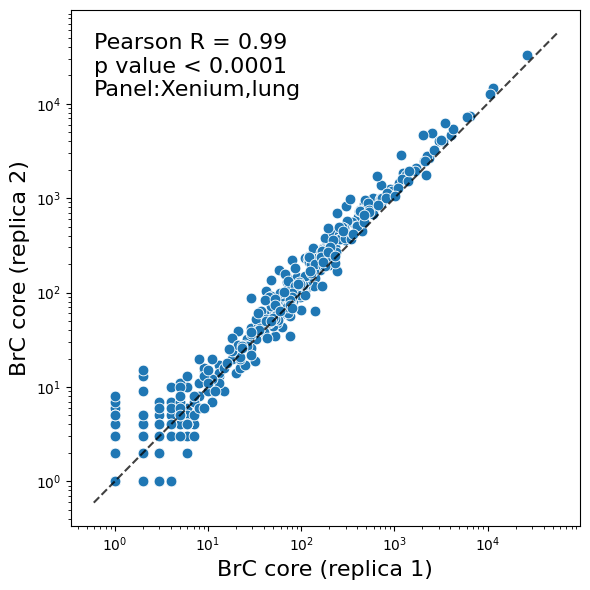

sample: merscope_breast_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


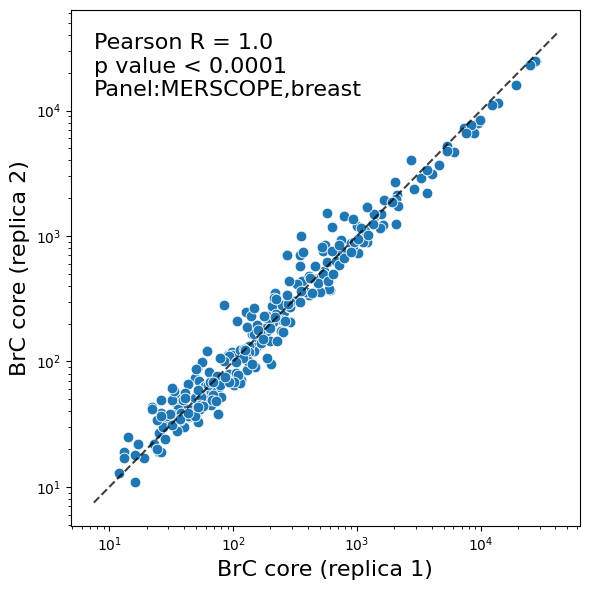

sample: merscope_lung_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


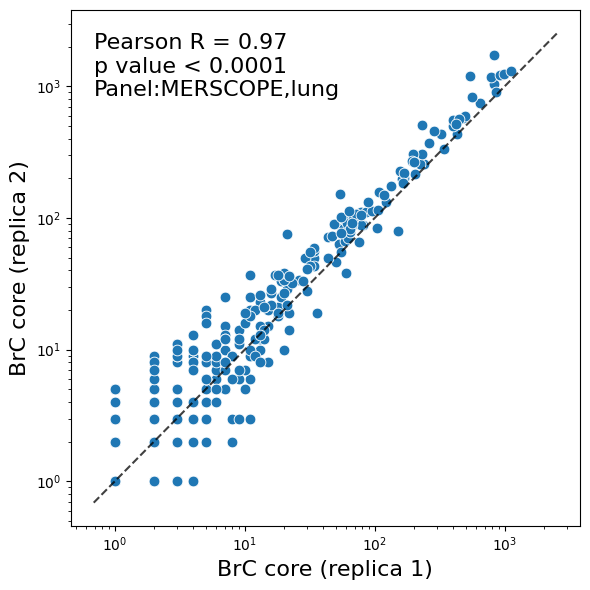

sample: cosmx_multitissue_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


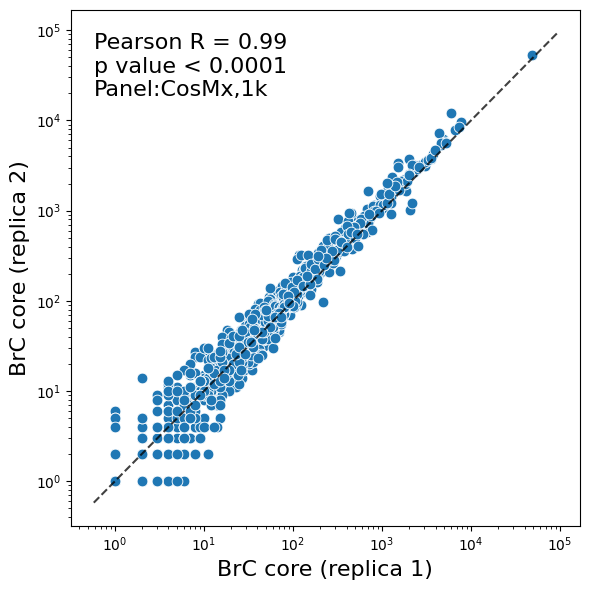

In [5]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

rs = []
sams = []
core_ps = []

for core_pair in [[105, 106]]:
    core_1 = core_pair[0]
    core_2 = core_pair[1]
    print (core_1, core_2)
    
    metric = f'count'
    df_m = pd.DataFrame()
    # for sample in ['xenium_lung_htma','merscope_breast_htma','cosmx_multitissue_htma']:
    for sample in SAMPLES[::2]:

        try:
            print (f'sample: {sample}')
            df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
            df_t = correct_tissue_names(sample, df_t)
            # Reindex normal tissue cores 
            df_t.core = df_t.core + 200 if 'normal' in sample else df_t.core
            platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[:2])]
            df_core_1 = df_t.loc[df_t['core']==core_1][['gene','tissue_type','count']]
            df_core_1 = df_core_1.rename(columns={'count':f'Core_{core_1}'})
            df_core_2 = df_t.loc[df_t['core']==core_2][['gene','count']]
            df_core_2 = df_core_2.rename(columns={'count':f'Core_{core_2}'})
            df_core_pair = pd.merge(df_core_1, df_core_2, on='gene', how='inner')
            df_core_pair['fold'] = df_core_pair.apply(lambda row: round(row[f'Core_{core_1}'] /row[f'Core_{core_2}']), axis=1)

            # Scatter plot
            plt.figure(figsize=(6, 6))
            sns.scatterplot(data=df_core_pair, x=f'Core_{core_1}', y=f'Core_{core_2}', s=60)

            r, p = sp.stats.pearsonr(x=df_core_pair[f'Core_{core_1}'], y=df_core_pair[f'Core_{core_2}'])
            p = '< 0.0001' if p < 0.0001 else round(p, 7)

            # Log scale
            plt.xscale('log')
            plt.yscale('log')

            lims1 = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            lims2 = [np.max([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            plt.plot(lims1, lims1, 'k--', alpha=0.75)
            fontsize = 16
            plt.text(lims1[0], lims1[1], f"Pearson R = {round(r,2)}\np value {p}\nPanel:{platform_panel}", fontsize=fontsize, verticalalignment='top')
            plt.xlabel(f'BrC core (replica 1)', fontsize=fontsize)
            plt.ylabel(f'BrC core (replica 2)', fontsize=fontsize)
            plt.tight_layout()
            plt.savefig(f'{wd}/figures/Fig_1/supp_1_Core_{core_1}_vs_Core_{core_2}_reproducibility_{platform_panel}.png', bbox_inches='tight')
            plt.savefig(f'{wd}/figures/Fig_1/supp_1_Core_{core_1}_vs_Core_{core_2}_reproducibility_{platform_panel}.eps', bbox_inches='tight')
            plt.show()

            rs.append(round(r,3))
            core_ps.append(f'Core {str(core_1).zfill(3)} vs. {str(core_2).zfill(3)}')
            sams.append(sample.upper())
        except:
            continue

In [6]:
rs = []
sams = []
core_ps = []

for core_pair in [[75, 76],
                [88, 89],
                [95, 96],
                [105, 106],
                [109, 110],
                [111, 112],
                [115, 116],
                [131, 132],
                [151, 152],
                [156, 157],
                [158, 159],
                [165, 166],
                [168, 169]]:
    core_1 = core_pair[0]
    core_2 = core_pair[1]
    print (core_1, core_2)


    metric = f'count'
    df_m = pd.DataFrame()
    # for sample in ['xenium_lung_htma','merscope_breast_htma','cosmx_multitissue_htma']:
    for sample in SAMPLES[::2]:

        try:
            print (f'sample: {sample}')
            df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
            df_t = correct_tissue_names(sample, df_t)
            # Reindex normal tissue cores 
            df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
            # Consolidate tissue type

            platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[:2])]

            df_core_1 = df_t.loc[df_t['core']==core_1][['gene','tissue_type','count']]
            df_core_1 = df_core_1.rename(columns={'count':f'Core_{core_1}'})
            df_core_2 = df_t.loc[df_t['core']==core_2][['gene','count']]
            df_core_2 = df_core_2.rename(columns={'count':f'Core_{core_2}'})
            df_core_pair = pd.merge(df_core_1, df_core_2, on='gene', how='inner')
            df_core_pair['fold'] = df_core_pair.apply(lambda row: round(row[f'Core_{core_1}'] /row[f'Core_{core_2}']), axis=1)
            r, p = sp.stats.pearsonr(x=df_core_pair[f'Core_{core_1}'], y=df_core_pair[f'Core_{core_2}'])
            p = '< 0.0001' if p < 0.0001 else round(p, 7)
            rs.append(round(r,3))
            core_ps.append(f'Core {str(core_1).zfill(3)} vs. {str(core_2).zfill(3)}')
            sams.append(sample.upper())
        except:
            continue


df = pd.DataFrame({'Sample':sams, 'Core Pair':core_ps, 'Correlation':rs})
df['Platform_Panel'] = df['Sample'].apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}")
df = correct_platform_panel(df, 'Platform_Panel')
df_plot = df.copy()
df_plot = df_plot.sort_values(by=['Core Pair'])
df_plot = df_plot.pivot(index='Platform_Panel', columns='Core Pair', values='Correlation')

75 76
sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: merscope_lung_htma
sample: cosmx_multitissue_htma
88 89
sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: merscope_lung_htma
sample: cosmx_multitissue_htma
95 96
sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: merscope_lung_htma
sample: cosmx_multitissue_htma
105 106
sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: merscope_lung_htma
sample: cosmx_multitissue_htma
109 110
sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: merscope_lung_htma
sample: cosmx_multitissue_htma
111 112
sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: 

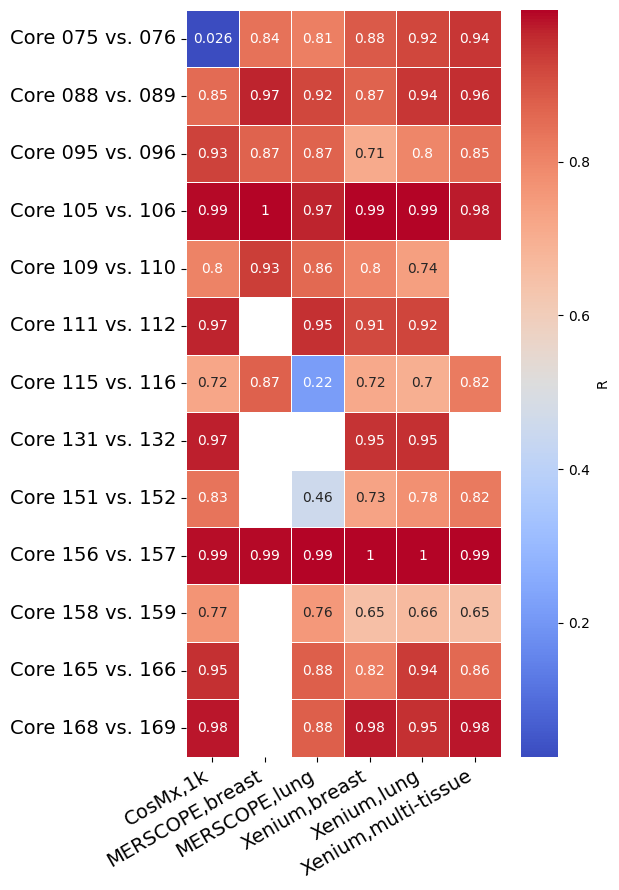

In [7]:
# Create the heatmap with annotations
plt.figure(figsize=(6, 9))
g = sns.heatmap(df_plot.T, annot=True, cmap='coolwarm', linewidths=0.5,cbar_kws={'label': 'R'})
cbar = g.collections[0].colorbar
cbar.ax.set_position([0.6, 0.1, 0.1, 0.77]) #
# cbar.ax.set_ylabel(f"{' '.join(metric.split('_')).capitalize()} per cell across tissue types by platform x panel", rotation=270, labelpad=20, fontsize=16)
plt.xlabel('')
plt.ylabel('')

fontsize=14
xlabels = g.get_xticklabels()
g.set_xticklabels(xlabels, fontsize=fontsize, rotation=30, ha="right")

ylabels = g.get_yticklabels()
g.set_yticklabels(ylabels, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f'{wd}/figures/Fig_1/supp_1_heatmap_of_core_reproducibility.png', dpi=250)
plt.savefig(f'{wd}/figures/Fig_1/supp_1_heatmap_of_core_reproducibility.eps', dpi=250)
plt.show()

In [40]:
df_t.dtypes

core            int64
gene           object
tissue_type    object
count           int64
code_type      object
sample         object
dtype: object

# Real sample to sample reproducibility

sample: xenium_breast_htma
sample: xenium_panhuman_htma
sample: xenium_lung_htma
sample: merscope_breast_htma
sample: merscope_lung_htma
sample: cosmx_multitissue_htma


sample: 2024_xenium_breast_htma
sample: 2024_merscope_breast_htma
sample: 2024_cosmx_multitissue_htma
xenium_breast_htma 2024_xenium_breast_htma


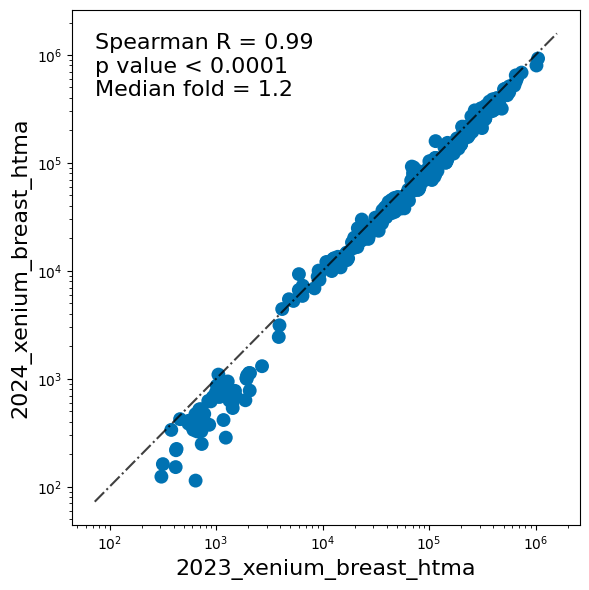

merscope_breast_htma 2024_merscope_breast_htma


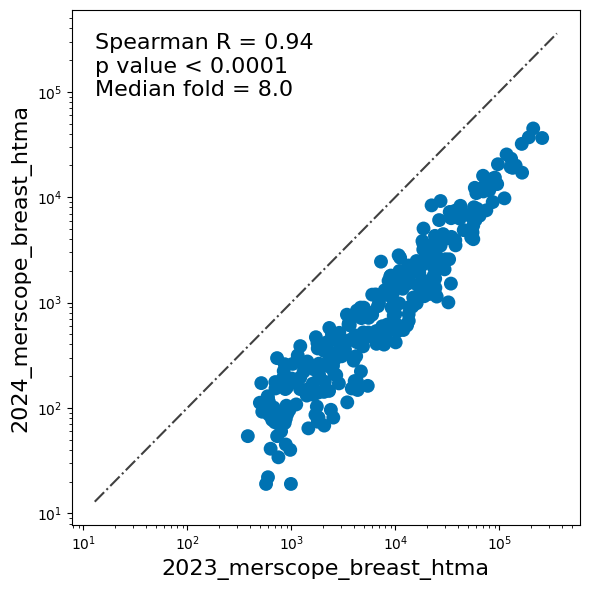

cosmx_multitissue_htma 2024_cosmx_multitissue_htma


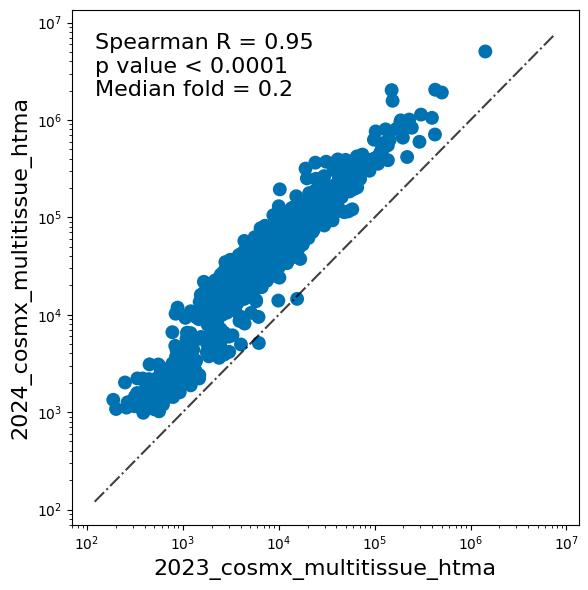

In [4]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

metric = f'count'
df_m = pd.DataFrame()
for sample in SAMPLES:
    if 'htma' in sample:
        print (f'sample: {sample}')
        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_t['sample'] = sample

        matching_cores = xenium_breast_htma_matching_cores if 'xenium' in sample else merscope_breast_htma_matching_cores if 'merscope' in sample else cosmx_multitissue_htma_matching_cores if 'cosmx' in sample else None
        df_t = df_t.loc[df_t['core'].isin(matching_cores)]
        df_m = pd.concat([df_m,df_t])
    
df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)[0].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)[1])

df_plot = df_m.copy()
df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

for count, sample_pair in enumerate([
    ('xenium_breast_htma','2024_xenium_breast_htma'),
    ('merscope_breast_htma','2024_merscope_breast_htma'),
    ('cosmx_multitissue_htma','2024_cosmx_multitissue_htma')
    ]):

    sample_1 = sample_pair[0]
    sample_2 = sample_pair[1]

    print(sample_1, sample_2)

    df_pair = df_plot[['gene', sample_1, sample_2]]
    df_pair = df_pair.reset_index(drop=True).dropna()

    df_pair['fold'] = df_pair.apply(lambda row: round(row[sample_1] /row[sample_2],1), axis=1)

    # Scatter plot
    plt.figure(figsize=(6, 6))
    color_index = 1
    sns.scatterplot(data=df_pair, x=sample_1, y=sample_2, color=list(CB_COLORS_5.values())[color_index],edgecolor='none',s=100)

    # # Annotate genes
    # for idx, row in df_pair.iterrows():
    #     plt.annotate(row['gene'], (row[platform_panel_1], row[platform_panel_2]), fontsize=5)

    r, p = sp.stats.spearmanr(df_pair[f"{sample_1}"], df_pair[f"{sample_2}"])
    p = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"

    # Log scale
    plt.xscale('log')
    plt.yscale('log')

    # 1:1 dashed line
    lims1 = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    lims2 = [np.max([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    plt.plot(lims1, lims1, 'k-.', alpha=0.75)
    fontsize = 16
    plt.text(lims1[0], lims1[1], f"Spearman R = {round(r,2)}\np value {p}\nMedian fold = {round(df_pair['fold'].median(), 1)}", fontsize=fontsize, verticalalignment='top')
    # plt.text(lims2[0] * 0.2, lims2[1], f"x=y line", fontsize=fontsize, verticalalignment='top')
    plt.xlabel(f"2023_{sample_1}", fontsize=fontsize)
    plt.ylabel(sample_2, fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{sample_1}_vs_{sample_2}.png", bbox_inches='tight', transparent=True)
    # plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{sample_1}_vs_{sample_2}.eps", bbox_inches='tight', transparent=True)
    # plt.close()
    plt.show()


## Real core to core reproducibility

['xenium_breast_htma', '2024_xenium_breast_htma']


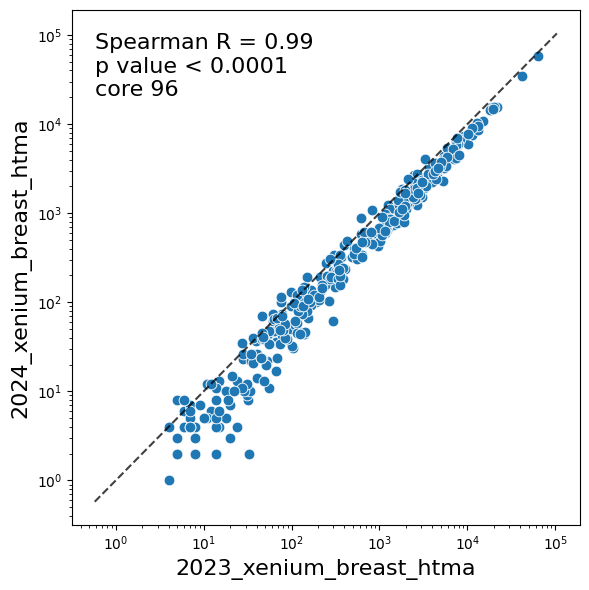

['merscope_breast_htma', '2024_merscope_breast_htma']


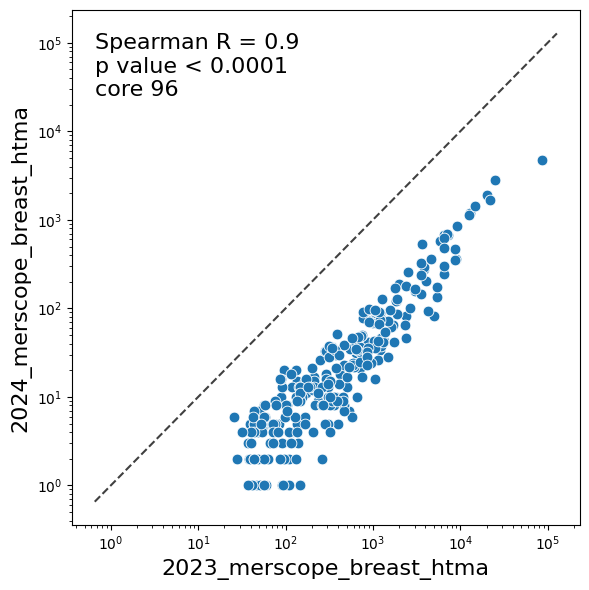

['cosmx_multitissue_htma', '2024_cosmx_multitissue_htma']


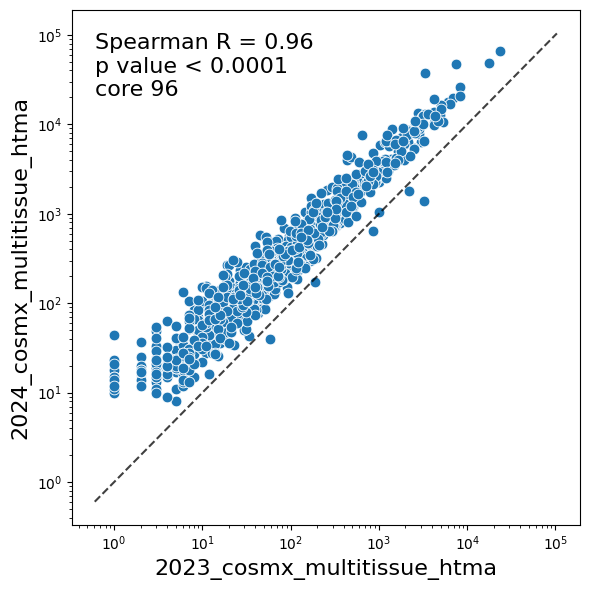

In [22]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

rs = []
cores = []
core_ps = []
distances = []

for sample_pair in [['xenium_breast_htma','2024_xenium_breast_htma'],
                    ['merscope_breast_htma','2024_merscope_breast_htma'],
                    ['cosmx_multitissue_htma','2024_cosmx_multitissue_htma']]:
    print (sample_pair)
    metric = f'count'
    df_m = {}

    for sample in sample_pair:
        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_sample = df_t[['gene','tissue_type','count','core']]
        df_sample = df_sample.rename(columns={'count':f'{sample}'})
        df_m[sample] = df_sample

    df_sample_pair = pd.merge(df_m[sample_pair[0]], df_m[sample_pair[1]], on=['core','gene','tissue_type'], how='inner')
    # df_sample_pair['fold'] = df_sample_pair.apply(lambda row: round(row[sample_pair[0]] /row[sample_pair[0]],2), axis=1)
    df_sample_pair['fold'] = df_sample_pair.apply(lambda row: row[sample_pair[0]] /row[sample_pair[0]], axis=1)

    for core in df_sample_pair.core.unique():
        df_core_plot = df_sample_pair.loc[df_sample_pair['core']==core]
        r, p = sp.stats.spearmanr(df_core_plot[sample_pair[0]], df_core_plot[sample_pair[1]])
        p = '< 0.0001' if p < 0.0001 else round(p, 7)

        # Calculate the perpendicular distances
        df_core_plot['distance'] = np.abs(df_core_plot[sample_pair[0]] - df_core_plot[sample_pair[1]]) / np.sqrt(2)

        # Calculate the overall average distance or any other statistical summary
        mean_distance = df_core_plot['distance'].mean()

        if core in [96]:
            # Scatter plot
            plt.figure(figsize=(6, 6))
            sns.scatterplot(data=df_core_plot, x=sample_pair[0], y=sample_pair[1], s=60)
            # Log scale
            plt.xscale('log')
            plt.yscale('log')
            lims1 = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            lims2 = [np.max([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            plt.plot(lims1, lims1, 'k--', alpha=0.75)
            fontsize = 16
            plt.text(lims1[0], lims1[1], f"Spearman R = {round(r,2)}\np value {p}\ncore {core}", fontsize=fontsize, verticalalignment='top')
            plt.xlabel(f"2023_{sample_pair[0]}", fontsize=fontsize)
            plt.ylabel(sample_pair[1], fontsize=fontsize)
            plt.tight_layout()
            plt.savefig(f"{wd}/figures/Fig_1/supp_1_Core_{core}_{sample_pair[0].split('_')[0]}_reproducibility.png", bbox_inches='tight')
            # plt.savefig(f"{wd}/figures/Fig_1/supp_1_Core_{core}_{sample_pair[0].split('_')[0]}_reproducibility.eps", bbox_inches='tight')
            plt.show()
            plt.close()

        rs.append(round(r,3))
        core_ps.append(f'{sample_pair[0]} vs. {sample_pair[1]}')
        cores.append(str(core))
        distances.append(mean_distance)


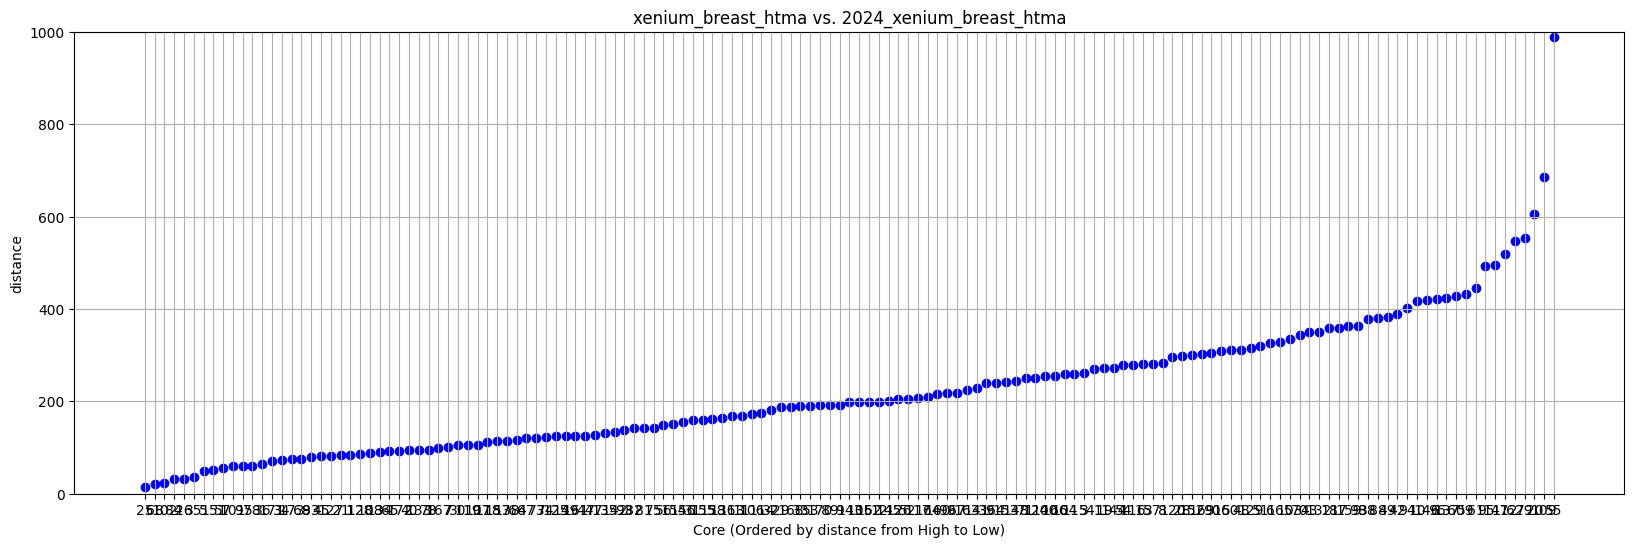

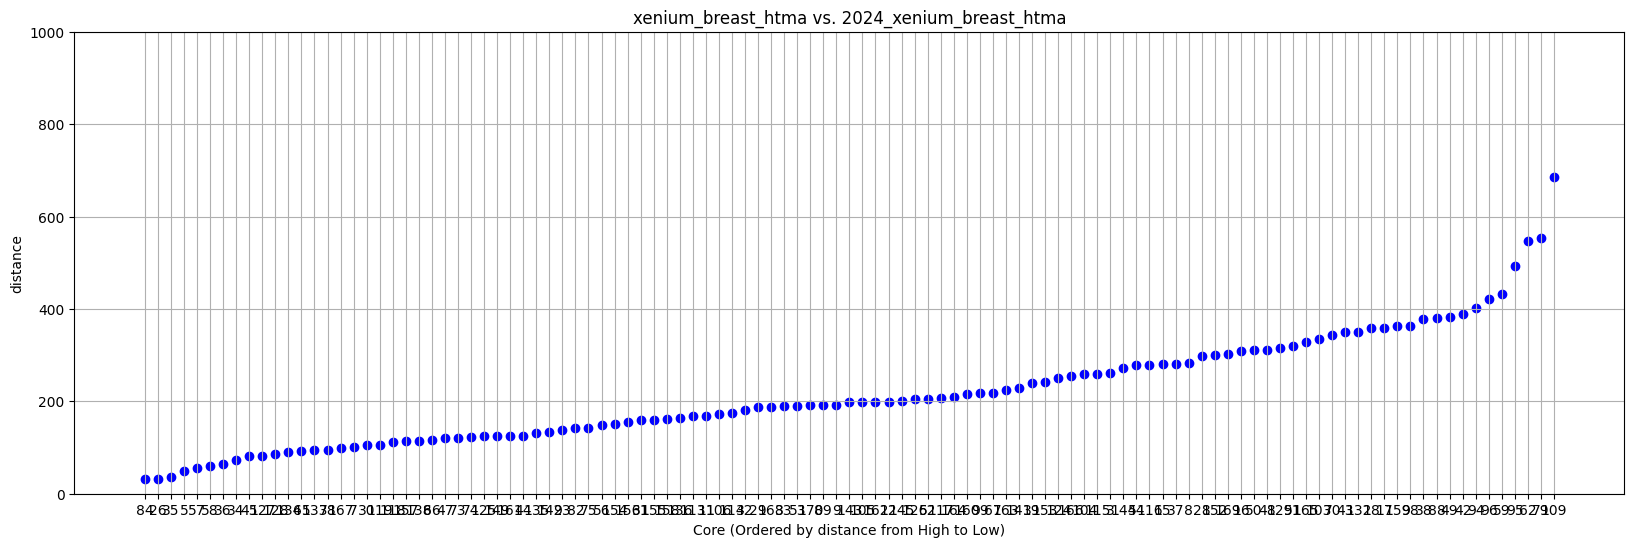

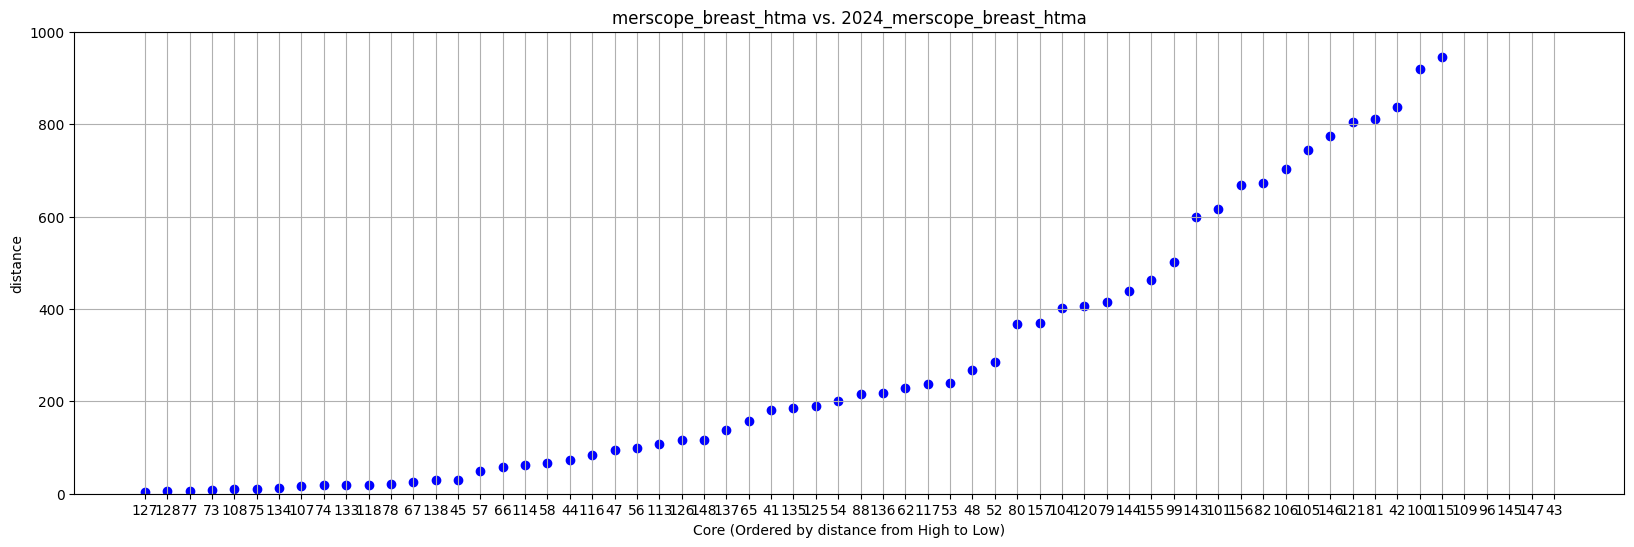

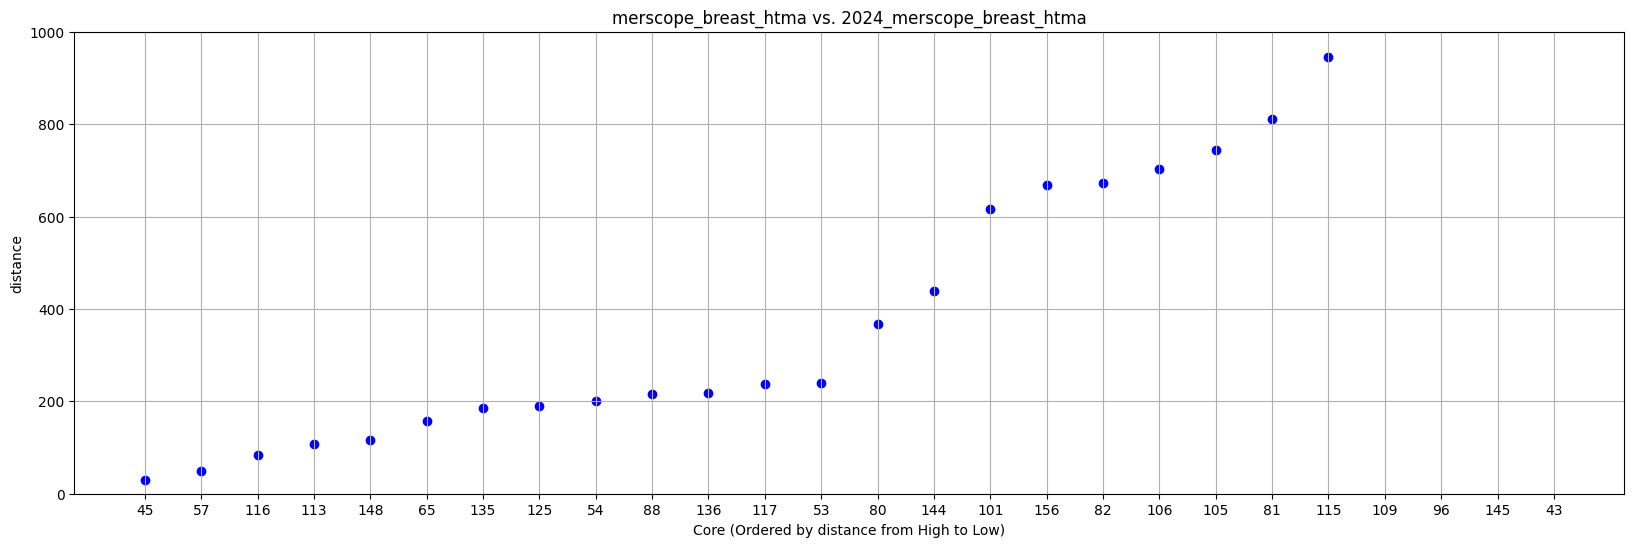

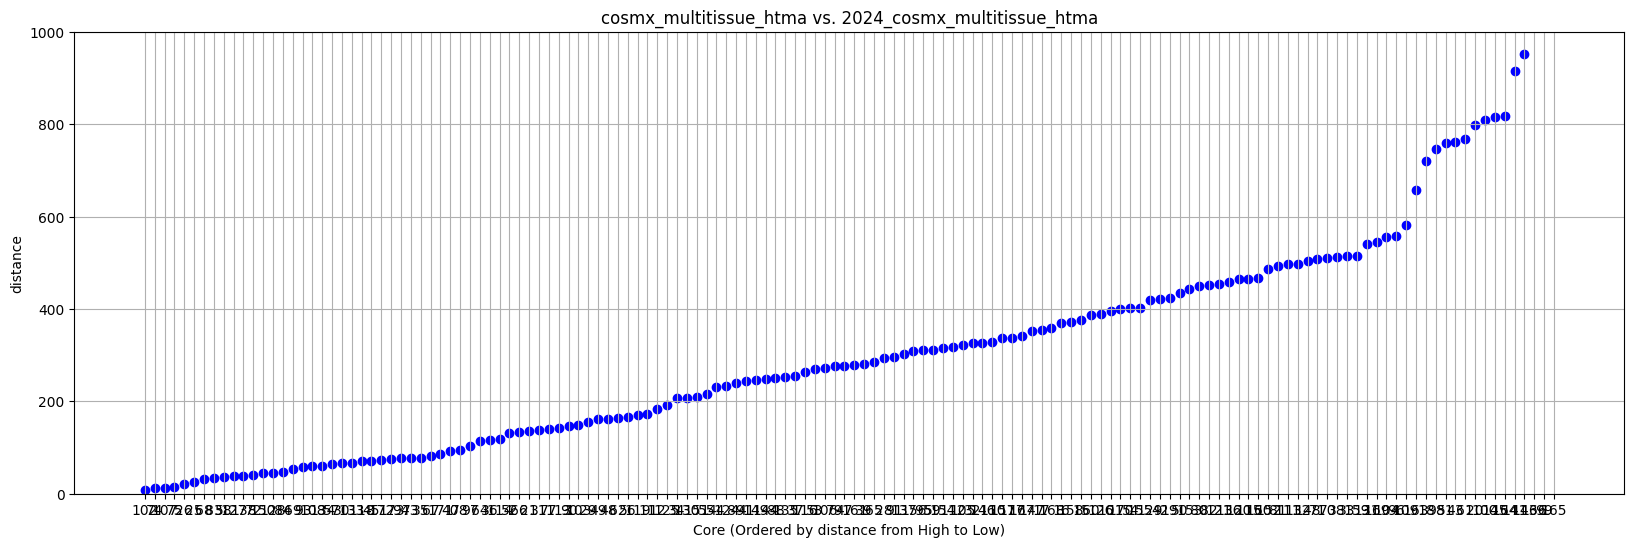

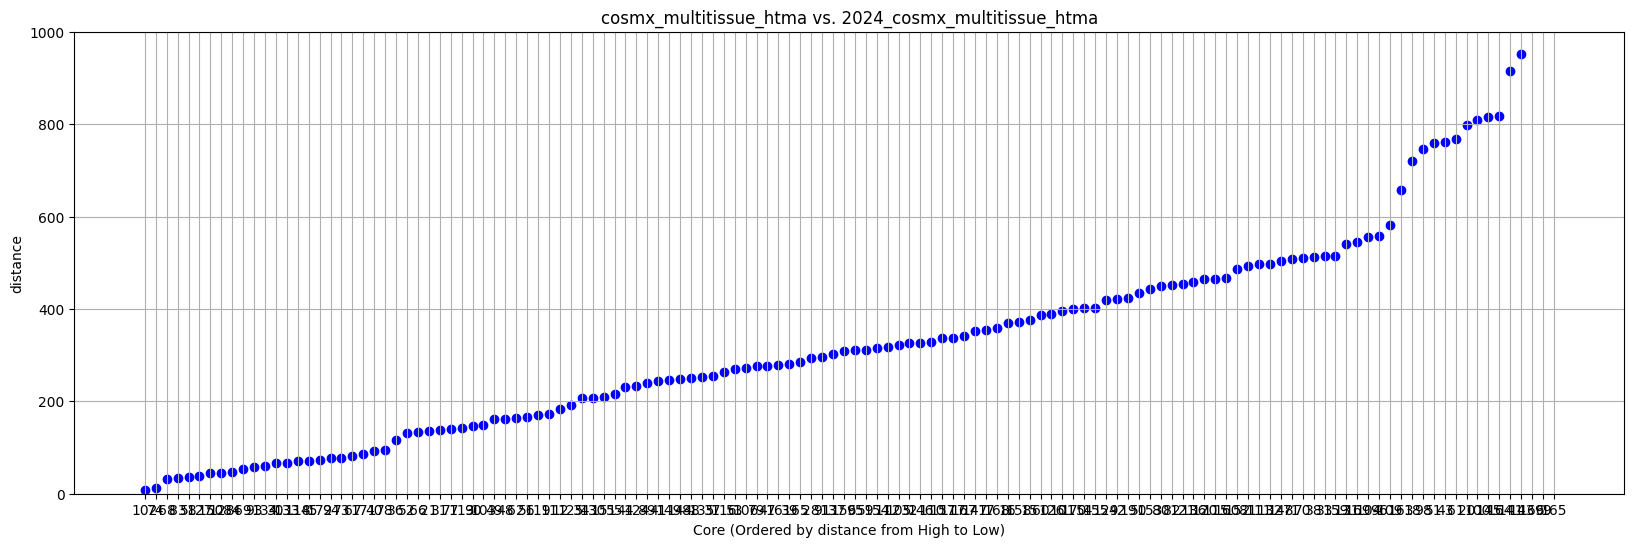

In [27]:
df_stats = pd.DataFrame({'pair':core_ps, 'core':cores, 'r':rs, 'distance':distances})

metric = 'r'
ylim = (0.3,1.0)

# metric = 'distance'
# ylim = (0,1000)

for pair in df_stats.pair.unique():
    df_plot = df_stats.loc[df_stats['pair']==pair]
    df_plot = df_plot.sort_values(by=['pair',metric])
    # df_stats[df_stats['r'] > 0.95].count()/df_stats.count()


    plt.figure(figsize=(20, 6))
    plt.scatter(df_plot['core'], df_plot[metric], color='blue')
    plt.title(pair)
    plt.xlabel(f'Core (Ordered by {metric} from High to Low)')
    plt.ylabel(metric)
    plt.grid(True)
    plt.ylim(ylim)

    plt.show()

    matching_cores = xenium_breast_htma_matching_cores if 'xenium' in pair else merscope_breast_htma_matching_cores if 'merscope' in pair else cosmx_multitissue_htma_matching_cores if 'cosmx' in pair else None
    df_plot_matcing = df_plot.loc[df_stats['core'].isin([str(x) for x in matching_cores])]
    
    plt.figure(figsize=(20, 6))
    plt.scatter(df_plot_matcing['core'], df_plot_matcing[metric], color='blue')
    plt.title(pair)
    plt.xlabel(f'Core (Ordered by {metric} from High to Low)')
    plt.ylabel(metric)
    plt.grid(True)
    plt.ylim(ylim)

    plt.show()

In [42]:
# Select cores that have matching morphology

df_stats['platform'] = df_stats['pair'].apply(lambda x: x.split('_')[0])
df_stats['platform'] = df_stats['platform'].apply(lambda x: f"{x.upper()}")
df_stats['core'] = df_stats['core'].astype(int)

filtered_df = df_stats.loc[
    ((df_stats['platform'] == 'XENIUM') & (df_stats['core'].isin(xenium_breast_htma_matching_cores))) |
    ((df_stats['platform'] == 'MERSCOPE') & (df_stats['core'].isin(merscope_breast_htma_matching_cores))) |
    ((df_stats['platform'] == 'COSMX') & (df_stats['core'].isin(cosmx_multitissue_htma_matching_cores)))
]


In [43]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Assuming df_new is your DataFrame and it's already defined
fig = go.Figure()

width=500
height=400
fontsize = 13

# Extract unique platforms to plot each as a separate box
platforms = filtered_df['platform'].unique()

for platform in platforms:
    data = filtered_df[filtered_df['platform'] == platform]['r']
    fig.add_trace(go.Box(
        y=data,
        name=platform,
        boxpoints='all',  # add all points
        jitter=0.3,  # adjust jitter to spread points horizontally
        pointpos=0  # adjust position relative to the box (-2 to 2)
    ))

# Set box plot settings
fig.update_traces(quartilemethod="exclusive")

# Customize axes and layout
fig.update_xaxes(title_text="", tickfont=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(title_text="Spearman R", title_font=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    width=width,
    height=height,
    title_text="Core level gene-by-gene correlation coefficient<br>2023 vs.2024",
    showlegend=False,
    title_font=dict(size=fontsize+2),
    legend_font=dict(size=fontsize),
    title_x=0.5,
    title_y=0.8,
    legend=dict(
        orientation="h",
        yanchor="bottom", 
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    font=dict(color='black'),
    plot_bgcolor= "rgba(0, 0, 0, 0)"
)

# Show the plot
fig.show()
pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility_spearmanr.png',scale=6, width=width, height=height)
# pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility.eps',scale=4, width=width, height=height)


In [44]:


# Assuming df_new is your DataFrame and it's already defined
fig = go.Figure()


# Extract unique platforms to plot each as a separate box
platforms = filtered_df['platform'].unique()
for platform in platforms:
    data = filtered_df[filtered_df['platform'] == platform]['distance']
    fig.add_trace(go.Box(
        y=data,
        name=platform,
        boxpoints='all',  # add all points
        jitter=0.3,  # adjust jitter to spread points horizontally
        pointpos=0  # adjust position relative to the box (-2 to 2)
    ))

# Set box plot settings
fig.update_traces(quartilemethod="exclusive")

# Customize axes and layout
fig.update_xaxes(title_text="", tickfont=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(title_text="Distance", title_font=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    width=width,
    height=height,
    title_text="Core level gene-by-gene distance to 1:1 line<br>2023 vs.2024",
    showlegend=False,
    title_font=dict(size=fontsize+2),
    legend_font=dict(size=fontsize),
    title_x=0.5,
    title_y=0.8,
    legend=dict(
        orientation="h",
        yanchor="bottom", 
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    font=dict(color='black'),
    plot_bgcolor= "rgba(0, 0, 0, 0)"
)

# Show the plot
fig.show()
pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility_distance.png',scale=6, width=width, height=height)
# pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility.eps',scale=4, width=width, height=height)
